#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.set_printoptions(3)

In [2]:
FILE_PATH = "train.csv"

In [3]:
data = pd.read_csv(FILE_PATH)

In [4]:
data.columns

Index(['date_time', 'deg_C', 'relative_humidity', 'absolute_humidity',
       'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5',
       'target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides'],
      dtype='object')

In [5]:
data.dtypes

date_time                  object
deg_C                     float64
relative_humidity         float64
absolute_humidity         float64
sensor_1                  float64
sensor_2                  float64
sensor_3                  float64
sensor_4                  float64
sensor_5                  float64
target_carbon_monoxide    float64
target_benzene            float64
target_nitrogen_oxides    float64
dtype: object

<AxesSubplot:>

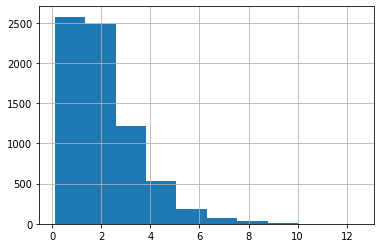

In [6]:
data.target_carbon_monoxide.hist()

<AxesSubplot:>

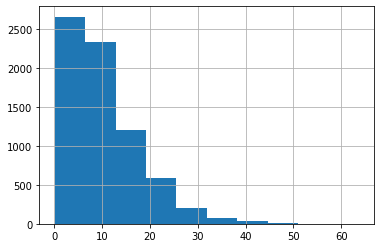

In [7]:
data.target_benzene.hist()

<AxesSubplot:>

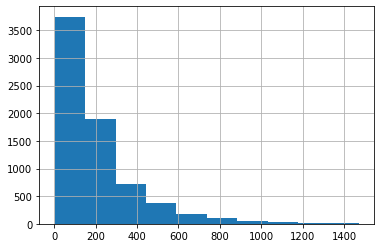

In [8]:
data.target_nitrogen_oxides.hist()

In [9]:
X = data.iloc[:, 1:-3].values
Y = data.iloc[:, -3:].values

In [10]:
n = X.shape[0]
X.shape, Y.shape, n

((7111, 8), (7111, 3), 7111)

In [11]:
shuffle_seed = np.random.seed(15)
index_train, index_val = np.split(np.random.permutation(n), [int(n * 0.8)])

In [12]:
X_train, Y_train = X[index_train], Y[index_train]

In [13]:
means, stds = X_train.mean(0, keepdims=True), X_train.std(0, keepdims=True)
assert stds.min() > 0.0

In [14]:
X_train = (X_train - means) / stds

# Jax

In [15]:
from typing import Optional, Sequence

import jax
import jax.numpy as jnp
import jax.random as random
from jax.tree_util import tree_map, tree_reduce

import flax.linen as nn
import optax

import tensorflow as tf
import tensorflow_datasets as tfds

In [16]:
class MLP(nn.Module):
    layer_sizes: Sequence[int]
    dropout: bool = False
    
    @nn.compact
    def __call__(self, x):
        
        for layer_ix, layer_size in enumerate(self.layer_sizes):
            x = nn.Dense(layer_size)(x)
            if layer_ix != len(self.layer_sizes) - 1:
                x = nn.relu(x)
                dropout_rate = 0.5
            else:
                dropout_rate = 0.2
            if self.dropout:
                x = nn.Dropout(deterministic=False, rate=dropout_rate)(x)
        return x

In [17]:
def poisson_loss(y, predicted):
    """
    Poisson NLL, parameterized so that `predicted` can take any scalar value (can be negative).
    """
    return - y * predicted + jnp.exp(predicted)

def squared_loss(y, predicted):
    return (y - predicted) ** 2

def weight_decay(scale, params_tree):
    l2_sum = jax.tree_util.tree_reduce(lambda x, y: x + jnp.sum(y**2), params_tree, initializer=0.0)
    dim = jax.tree_util.tree_reduce(lambda x, y: x + jnp.prod(jnp.array(y.shape)), params_tree, initializer=0.0)
    return scale * l2_sum / dim

In [18]:
def get_dataset(x_data, y_data, batch_size):
    data = tf.data.Dataset.from_tensor_slices((x_data, y_data))
    data = data.shuffle(buffer_size=1000)
    data = data.batch(batch_size)
    return tfds.as_numpy(data)

In [19]:
def train_step(params, opt_state, x, y, model, optimizer, loss_fn, metric_fn, l2_scale):
    def pure_loss(params):
        predicted = model.apply(params, x)
        return jnp.mean(jnp.mean(loss_fn(y, predicted), 0)) + weight_decay(scale=l2_scale, params_tree=params)
    loss_step, grad_step = jax.value_and_grad(pure_loss)(params)
    param_updates, opt_state = optimizer.update(grad_step, opt_state)
    metric_step = jnp.mean(jnp.mean(metric_fn(y, model.apply(params, x)), 0))
    params = optax.apply_updates(params, param_updates)
    return params, opt_state, loss_step, metric_step

In [20]:
def train(rng, model, optimizer, dataset, loss_fn, metric_fn, num_epochs, inputs_shape, l2_scale=0.0):
 
    rng, init_key = random.split(rng)
    dummy_input = random.normal(init_key, shape=inputs_shape)

    rng, init_key = random.split(rng)
    params = model.init(init_key, dummy_input)

    opt_state = optimizer.init(params)

    for epoch_ix in range(num_epochs):
        step = 0
        for (x_train, y_train) in dataset:
            params, opt_state, loss_step, metric_step = train_step(params, opt_state, x_train, y_train, model, optimizer, loss_fn, metric_fn, l2_scale)
            step += 1
            if step % 25 == 0:
                print(f"Step {step}, Metric: {metric_step:.3f}, Loss: {loss_step:.3f}")
    return params

In [21]:
p, m = X_train.shape[1], Y_train.shape[1]
num_h_layers = 0
h = 16  # hidden layer size
lr = 1e-4  # learning rate
num_epochs = 2
batch_size = 32

jax_poisson = jax.vmap(jax.jit(poisson_loss), in_axes=0)
jax_squared = jax.vmap(jax.jit(squared_loss), in_axes=0)

In [22]:
trained_params = train(rng=random.PRNGKey(15),
      model=MLP([h for _ in range(num_h_layers)] + [m]),
      optimizer=optax.adam(lr),
      dataset=get_dataset(X_train, Y_train, batch_size),
      loss_fn=jax_squared,
      metric_fn=lambda a, b: jnp.sqrt(jax_squared(a, b)),
      num_epochs=num_epochs,
      inputs_shape=(1, p)
     )

Step 25, Metric: 64.284, Loss: 18521.490


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7febc981cee0>
Traceback (most recent call last):
  File "/home/arnaud15/miniconda3/envs/jax/lib/python3.9/weakref.py", line 367, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


Step 50, Metric: 75.997, Loss: 29222.572
Step 75, Metric: 85.385, Loss: 34530.777


KeyboardInterrupt: 

## Roadmap
- [x] load data into a tf dataset in memory 
- [x] create a dummy MLP and training loop
- [x] debug MLP on linear regression
- [x] Add dummy regularization and make it a baby resnet
    - Going for dropout and weight decay
- [ ] Split code nicely into several files
- [ ] Unit tests
    - Understand how to specify neural net parameters init
    - Understand init rngs and nn.module
    - debug simple resnet training
- [ ] Checkpointing and evaluation
- [ ] Tensorboard
- [ ] Baby version submission
- [ ] GPU training on AWS
- [ ] Rayon for training on several instances at the same time
- [ ] Go all in on hyperparameters tuning

### Notes
- Understand `nn.compact`
- Check out the source code for their train state

In [23]:
n = 10000
p = 10

key = random.PRNGKey(1515)
key, init_key = random.split(key)
X_linear = random.normal(init_key, shape=(n, p))
key, init_key = random.split(key)
beta = random.uniform(init_key, shape=(p,))
key, init_key = random.split(key)
noise = random.normal(init_key, shape=(n,))

y_linear = noise + X_linear.dot(beta)

In [46]:
class Resnet(nn.Module):
    layer_sizes: Sequence[int]
    dropout: bool = False
    
    @nn.compact
    def __call__(self, x, train=True):
        n_layers = len(self.layer_sizes)
        for (layer_ix, layer_size) in enumerate(self.layer_sizes):
            residual = x
            x = nn.Dense(layer_size)(x)
            if layer_ix == n_layers - 1:
                dropout_rate = 0.2
            else:
                x += residual
                x = nn.relu(x)
                dropout_rate = 0.5
            x = nn.Dropout(dropout_rate, deterministic=not train)(x)
        return x

In [47]:
trained_params = train(rng=random.PRNGKey(15),
      model=Resnet([10, 1]),
      optimizer=optax.sgd(5 * 1e-3),
      dataset=get_dataset(X_linear, y_linear, batch_size=32),
      loss_fn=jax_squared,
      metric_fn=jax_squared,
      num_epochs=5,
      inputs_shape=(1, p),
      l2_scale=1e-3,
     )

InvalidRngError: Dropout_0 needs PRNG for "dropout" (https://flax.readthedocs.io/en/latest/flax.errors.html#flax.errors.InvalidRngError)

In [48]:
beta

DeviceArray([0.598, 0.801, 0.642, 0.097, 0.51 , 0.226, 0.171, 0.31 ,
             0.386, 0.39 ], dtype=float32)

In [49]:
test_key = random.PRNGKey(12097341324)
test_input = random.normal(test_key, shape=(10,))
test_input.dot(beta)

DeviceArray(0.406, dtype=float32)

In [50]:
void_resnet = Resnet([10, 1])

void_resnet.init(test_key, test_input)

InvalidRngError: Dropout_0 needs PRNG for "dropout" (https://flax.readthedocs.io/en/latest/flax.errors.html#flax.errors.InvalidRngError)

In [51]:
void_resnet.apply(trained_params, test_input, train=False)

DeviceArray([0.042], dtype=float32)